# Script to add endogenous attributes to input data




In [19]:
import os
import pandas as pd

def process_attributes_csv(model_name):
    data_folder = f'../data/{model_name}'  # Go back one level to reach the data folder

    # Ensure the data folder exists
    if not os.path.exists(data_folder):
        print(f"Error: Data folder '{data_folder}' not found.")
        return

    # Function to find 'attributes.csv' in subfolders
    def find_attributes_csv(folder):
        for root, dirs, files in os.walk(folder):
            if 'attributes.csv' in files:
                return os.path.join(root, 'attributes.csv')
        return None

    attributes_csv = find_attributes_csv(data_folder)

    # Check if the 'attributes.csv' file exists in any subfolder
    if attributes_csv is None:
        print(f"Error: 'attributes.csv' not found in any subfolder of '{data_folder}'.")
        return

    # Read the 'attributes.csv' file into a DataFrame
    df = pd.read_csv(attributes_csv)

    # Add the specified lines to the DataFrame
    new_lines = [
        {'num_pwa_segments_default': ',7,'},
        {'learning_rate_default': ',-0.074,'},
        {'global_share_default': '1'},
        {'learning_curve_lower_bound_default': ', 0,'},
        {'learning_curve_upper_bound_default':', 200,'},
        {'learning_curve_npts_default': '1000,'},
        {'global_initial_capacity_default':', 50,'},
    ]

    # Use loc to add new rows to the DataFrame
    for line in new_lines:
        df.loc[len(df)] = line

    # Save the modified DataFrame back to the 'attributes.csv' file, overwriting the original content
    df.to_csv(attributes_csv, index=False)

    print(f"Processed 'attributes.csv' in subfolder: {os.path.dirname(attributes_csv)} and added lines.")

if __name__ == "__main__":
    model_name = "20240118_Hydrogen_vAX/set_technologies"
    process_attributes_csv(model_name)


Processed 'attributes.csv' in subfolder: ../data/20240118_Hydrogen_vAX/set_technologies\set_conversion_technologies\anaerobic_digestion and added lines.


# Initialise data

In [1]:
import numpy as np
%matplotlib inline

def fun_total_cost(u, c_initial: float, q_initial: float,
                           learning_rate: float) -> object:  # u is a vector
            """
            Total cumulative Cost for Learning Curve
            :param u: Cumulative Capacity
            :param c_initial: Initial Cost
            :param q_initial: Initital Capacity
            :param learning_rate: Learning Rate
            :return: Total cumulative cot
            """
            alpha = c_initial / np.power(q_initial, learning_rate)
            exp = 1 + learning_rate
            TC = alpha / exp * ( np.power(u, exp) )
            return TC

x_values = np.linspace(0,200, 1000)
c_initial = 1/8760 * 761
q_initial = 60
learning_rate = -0.54
y_values = fun_total_cost(x_values, c_initial, q_initial, learning_rate)

# Option 1: PWA 
This can only do the number of segments that are specified in def piecewise_linear

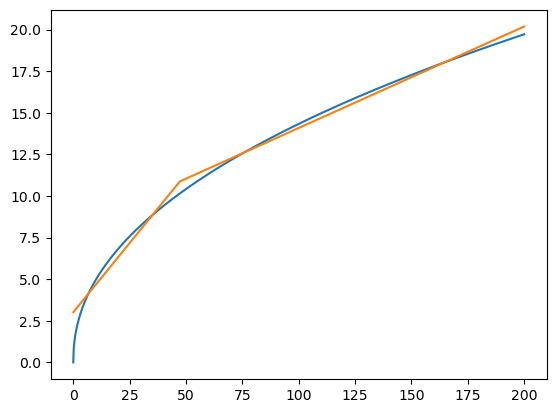

In [5]:
from scipy import optimize
import matplotlib.pyplot as plt

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

p , e = optimize.curve_fit(piecewise_linear, x_values, y_values)
plt.plot(x_values, y_values)
plt.plot(x_values, piecewise_linear(x_values, *p))

# Option 2: PWA with multiple segments



                    Breakpoint Regression Results                     
No. Observations                     1000
No. Model Parameters                    4
Degrees of Freedom                    996
Res. Sum of Squares               116.527
Total Sum of Squares              20191.0
R Squared                        0.994229
Adjusted R Squared               0.994206
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                3.03292       0.0442       68.612           0.0       2.9462       3.1197
alpha1              0.165452      0.00161       102.64           0.0      0.16229      0.16862
beta1              -0.104577      0.00164       -63.91             -     -0.10779     -0.10137
breakpoint1          47.5445        0.486            -             -       46.591       48.498
-----------------

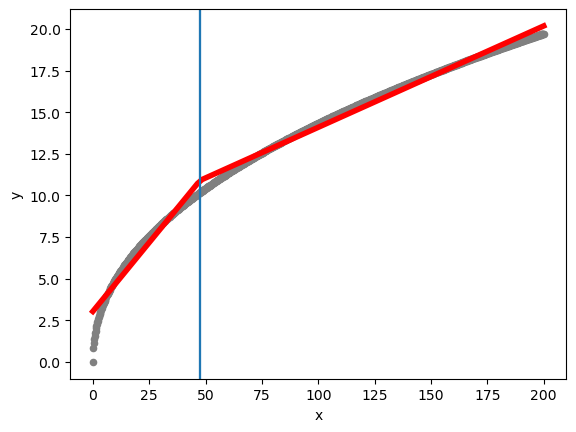

In [2]:
import piecewise_regression
import matplotlib.pyplot as plt

pw_fit = piecewise_regression.Fit(x_values, y_values, n_breakpoints=1)
pw_fit.summary()

# Print a summary of the fit
pw_fit.summary()

# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

# Option 2 (ext): PWA with multiple segements and incremental determination of number of breakpoints

Successful fit with 2 breakpoints.
Mean squared error is 0.029131041921572412


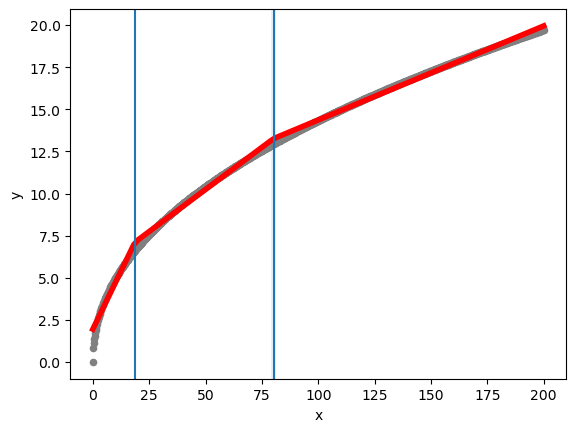

In [8]:
import piecewise_regression
import matplotlib.pyplot as plt

n = 2
max_n = 10
while n < max_n:
    pw_fit = piecewise_regression.Fit(x_values, y_values, n_breakpoints=n)
    # check if successful fit
    if pw_fit.get_params()["converged"]:
        print(f"Successful fit with {n} breakpoints.")
        x_hat =np.linspace(0, 200, 2000)
        y_hat = pw_fit.predict(x_hat)
        y_true = fun_total_cost(x_hat, c_initial, q_initial, learning_rate)
        mean_sq_error = np.mean(np.power((y_hat - y_true),2))
        if mean_sq_error < 0.05:
            print(f"Mean squared error is {mean_sq_error}")
            break
        else: 
            n += 1
    else:
        print(f"Failed fit with {n} breakpoints.")
        n -= 1
        pw_fit = piecewise_regression.Fit(x_values, y_values, n_breakpoints=n)
        break

# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [10]:
pw_fit.best_muggeo.best_fit.r_squared

0.9942287687203828

# Extract the PWA parameters 

In [157]:
raw_params =  pw_fit.best_muggeo.best_fit.raw_params
breakpoints = pw_fit.best_muggeo.best_fit.next_breakpoints

# Find TC_interpolated
TC_interpolated_first = np.array([raw_params[0]])
TC_interpolated_next = pw_fit.predict(breakpoints)
TC_interpolated= np.concatenate((TC_interpolated_first, TC_interpolated_next))

# Find the y-intersects
tossed_params = raw_params[1:]

# Initialize with the second entry
result = raw_params[1]

# List to store intermediate results
slope = [result]

# Iteratively sum each pair of values in tossed_params with the result from the previous sum
for i in range(0, len(breakpoints)):
    result +=  tossed_params[i + 1]
    slope.append(result)

print(slope)


[0.2761779989592156, 0.09990638532923207, 0.055810576150662414]


# Extract Parameters lik ein technology.py script

In [50]:
raw_params = pw_fit.best_muggeo.best_fit.raw_params
breakpoints = pw_fit.best_muggeo.best_fit.next_breakpoints

# Find the interpolated_x
interpolated_x_first = np.array([x_values[0]])
interpolated_x_next = breakpoints
interpolated_x_last = np.array([x_values[-1]])
interpolated_x = np.concatenate((interpolated_x_first, interpolated_x_next, interpolated_x_last))

# Find TC_interpolated
TC_interpolated = pw_fit.predict(interpolated_x)

# Find the y-intersects
tossed_params = raw_params[1:]

# Initialise list of slope with first raw param from fit 
slope = []
# Iteratively sum each pair of values in tossed_params with the result from the previous sum
result = 0
for i in range(0, len(breakpoints)+1):
    result += tossed_params[i]
    slope.append(result)

# Determine intersect
intersect = TC_interpolated[:-1] - slope * interpolated_x[:-1]

# Plot the functions 

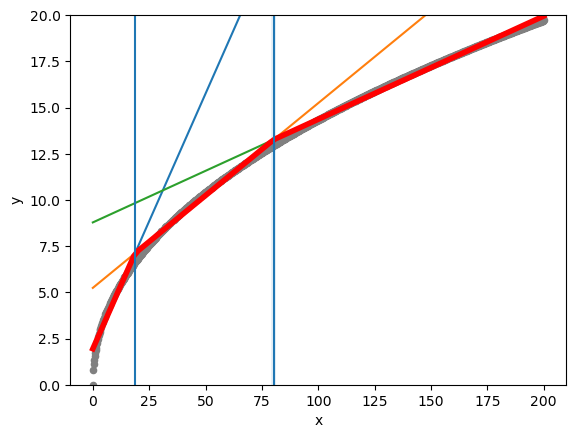

In [51]:
y1 = slope[0]*x_values + intersect[0]
y2 = slope[1]*x_values + intersect[1]
y3 = slope[2]*x_values + intersect[2]

plt.plot(x_values, y1)
plt.plot(x_values, y2)
plt.plot(x_values, y3)# Pass in standard matplotlib keywords to control any of the plots
# Plot the data, fit, breakpoints and confidence intervals
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0,20)
plt.show()

# Add endogenous learning to attributes

In [180]:
import os
import json

def replace_last_two_lines_with_lines(folder_path, file_name, lines_to_replace):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file == file_name and file.lower().endswith('.json'):
                file_path = os.path.join(root, file)

                with open(file_path, 'r') as f:
                    lines = f.readlines()

                # Remove the last two lines
                lines = lines[:-2]

                # Add the new lines with line breaks
                lines.extend('\n'.join(lines_to_replace))

                with open(file_path, 'w') as f:
                    f.writelines(lines)

# Specify the relative path to the folder
relative_folder_path = '../data/Test_set_for_preprocessing/set_technologies'

# Get the absolute path based on the current working directory
absolute_folder_path = os.path.abspath(relative_folder_path)

# New lines to replace the last two lines
new_lines_to_replace = [
    """
    },
    {
        "global_share": {
          "default_value": 1.0,
          "unit": "1"
        }
      },
      {
        "learning_curve_lower_bound": {
          "default_value": 0.0,
          "unit": "1"
        }
      },
      {
        "learning_curve_upper_bound": {
          "default_value": 200.0,
          "unit": "1"
        }
      },
      {
        "learning_curve_npts": {
          "default_value": 1000.0,
          "unit": "1"
        }
      },
      {
        "global_initial_capacity": {
          "default_value": 50.0,
          "unit": "GW"
        }
      }
    ]"""
    ]

# Example usage:
file_name = 'attributes.json'
replace_last_two_lines_with_lines(absolute_folder_path, file_name, new_lines_to_replace)


# Telegram bot

In [1]:
from telegram import Bot

# Your Telegram bot token
TOKEN = '6585556167:AAGDTMRiK9BZEsjjTBT1_m57c-92USqVdRI'

# ID of the chat where you want to send the message
CHAT_ID = '5778346437'

def send_telegram_message(message):
    bot = Bot(token=TOKEN)
    bot.send_message(chat_id=CHAT_ID, text=message)

if __name__ == "__main__":
    message = "Hello, this is a test message from your Python script!"
    send_telegram_message(message)


C:\Users\Anya Xie\AppData\Local\Temp\ipykernel_16540\1091421835.py:11: RuntimeWarning: coroutine 'Bot.send_message' was never awaited
  bot.send_message(chat_id=CHAT_ID, text=message)


In [2]:
import requests
TOKEN = "6585556167:AAGDTMRiK9BZEsjjTBT1_m57c-92USqVdRI"
url = f"https://api.telegram.org/bot{TOKEN}/getUpdates"
print(requests.get(url).json())

{'ok': True, 'result': []}


In [4]:
import asyncio
from telegram import Bot

# Your Telegram bot token
TOKEN = '6585556167:AAGDTMRiK9BZEsjjTBT1_m57c-92USqVdRI'

# ID of the chat where you want to send the message
CHAT_ID = '5778346437'

async def send_telegram_message(message):
    bot = Bot(token=TOKEN)
    await bot.send_message(chat_id=CHAT_ID, text=message)

async def main():
    message = "Hello, this is a test message from your Python script!"
    await send_telegram_message(message)

if __name__ == "__main__":
    asyncio.run(main())


RuntimeError: asyncio.run() cannot be called from a running event loop